[ WARN:0] global ./modules/videoio/src/cap_gstreamer.cpp (1100) open OpenCV | GStreamer warning: Cannot query video position: status=1, value=3, duration=-1


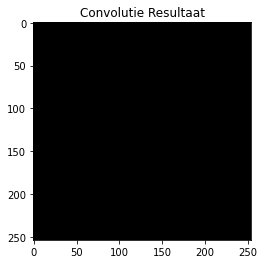

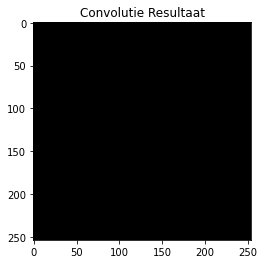

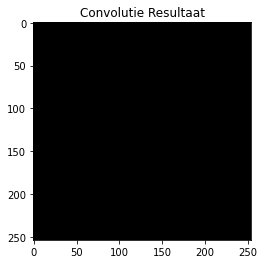

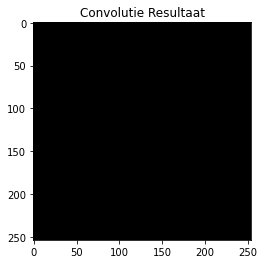

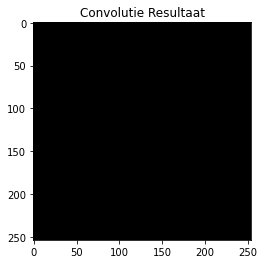

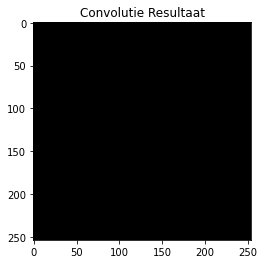

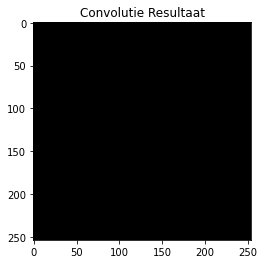

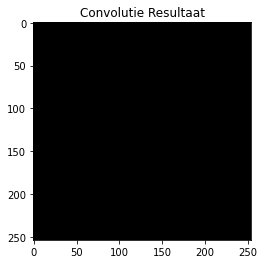

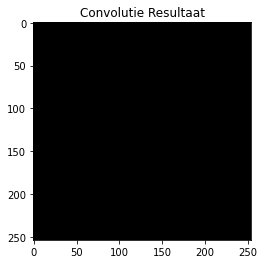

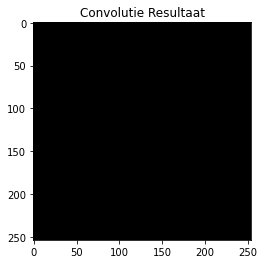

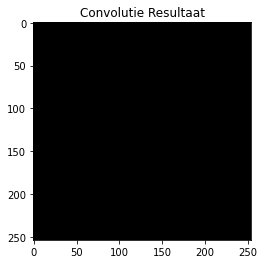

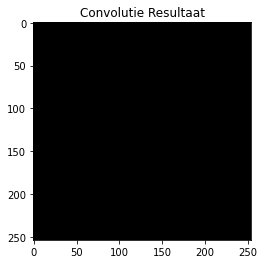

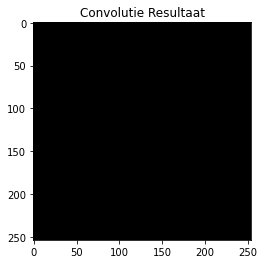

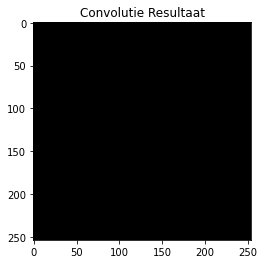

KeyboardInterrupt: 

In [3]:
import numpy as np
import cv2
from pynq import Overlay, allocate
from PIL import Image
import matplotlib.pyplot as plt

# Overlay laden (controleer of je de juiste bitstream hebt)
overlay = Overlay("design_1_wrapper.bit")
conv_ip = overlay.conv2d_edge_0  # Controleer de juiste naam van je convolution IP

# GStreamer pipeline voor MJPEG-ondersteuning
gst_str = (
    "v4l2src device=/dev/video0 ! "
    "image/jpeg, width=640, height=480, framerate=30/1 ! "
    "jpegdec ! "
    "videoconvert ! "
    "appsink"
)

# Open de camera via GStreamer
cap = cv2.VideoCapture(gst_str, cv2.CAP_GSTREAMER)

# Controleer of de webcam is geopend
if not cap.isOpened():
    raise Exception("Kan de webcam niet openen via GStreamer!")

# Continu beeld ophalen en verwerken
while True:
    ret, frame = cap.read()
    if not ret:
        print("Kan geen frame lezen.")
        break

    # Zet het beeld om naar greyscale en schaal het naar 256x256
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    resized_frame = cv2.resize(gray_frame, (256, 256))

    # Verwerken van het frame met convolutie
    img_array = resized_frame.astype(np.uint8)

    # Alloceren van buffers voor convolutie
    in_buffer = allocate(shape=(256, 256), dtype=np.uint8)
    out_buffer = allocate(shape=(254, 254), dtype=np.uint8)  # Aangepast voor kernelgrootte

    np.copyto(in_buffer, img_array)

    # Schrijf adressen naar het IP
    in_addr = in_buffer.physical_address
    out_addr = out_buffer.physical_address

    
    
    # Start convolutie
    conv_ip.write(0x10, in_addr)  # Stel de input buffer in
    conv_ip.write(0x18, out_addr)  # Stel de output buffer in
    conv_ip.write(0x00, 0x01)  # Start de convolutie

    # Wacht tot de convolutie klaar is
    while conv_ip.read(0x00) & 0x4 == 0:  # Controleer de AP_DONE bit
        pass

    # Resultaat ophalen
    np.copyto(out_buffer, out_buffer)  # Kopieer de output naar de buffer
    result_image = out_buffer[:254, :254]  # Gebruik het correcte resultaatformaat

    # Visualiseer de output
    plt.imshow(result_image, cmap='gray')
    plt.title("Convolutie Resultaat")
    plt.show()

    # Wacht even voor de volgende frame
    if cv2.waitKey(1) & 0xFF == ord('q'):  # Druk 'q' in om de feed te stoppen
        break

# Geef de bronnen vrij
cap.release()


In [2]:
cap = cv2.VideoCapture(0)  # Open de camera zonder GStreamer

# Controleer of de webcam is geopend
if not cap.isOpened():
    raise Exception("Kan de webcam niet openen!")


[ WARN:0] global ./modules/videoio/src/cap_gstreamer.cpp (2075) handleMessage OpenCV | GStreamer warning: Embedded video playback halted; module v4l2src1 reported: Device '/dev/video0' is busy
[ WARN:0] global ./modules/videoio/src/cap_gstreamer.cpp (1053) open OpenCV | GStreamer warning: unable to start pipeline
[ WARN:0] global ./modules/videoio/src/cap_gstreamer.cpp (616) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ WARN:0] global ./modules/videoio/src/cap_v4l.cpp (890) open VIDEOIO(V4L2:/dev/video0): can't open camera by index


Exception: Kan de webcam niet openen!

In [14]:
import cv2
print(cv2.__version__)


4.5.4


In [5]:
import numpy as np
import cv2
from time import time

# GStreamer pipeline
gst_str = (
    "v4l2src device=/dev/video0 ! "  # pas device aan indien nodig
    "image/jpeg, width=640, height=480, framerate=30/1 ! "
    "jpegdec ! "
    "videoconvert ! "
    "appsink"
)

cap = cv2.VideoCapture(gst_str, cv2.CAP_GSTREAMER)
if not cap.isOpened():
    raise Exception("Kan de webcam niet openen via GStreamer!")

# VideoWriters aanmaken om beelden op te slaan op SD-kaart
fourcc = cv2.VideoWriter_fourcc(*'XVID')  # Gebruik .avi of .mp4 (afhankelijk van codec)

out_original = cv2.VideoWriter('/home/xilinx/jupyter_notebooks/webcam_original.avi', fourcc, 15, (640, 480))
out_gray = cv2.VideoWriter('/home/xilinx/jupyter_notebooks/webcam_gray.avi', fourcc, 15, (640, 480), isColor=False)
out_resized = cv2.VideoWriter('/home/xilinx/jupyter_notebooks/webcam_256.avi', fourcc, 15, (256, 256), isColor=False)

start = time()
duration = 15  # seconden

while time() - start < duration:
    ret, frame = cap.read()
    if not ret:
        print("Kan geen frame lezen.")
        break

    # Origineel wegschrijven
    out_original.write(frame)

    # Grayscale en resized beelden genereren
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    resized = cv2.resize(gray, (256, 256))

    # Grayscale wegschrijven
    out_gray.write(gray)

    # 256x256 (input voor convolutie) wegschrijven
    out_resized.write(resized)

    # Optioneel: toon live beeld in notebook (verwijder bij performanceproblemen)
    # cv2.imshow("Live input", frame)
    # if cv2.waitKey(1) & 0xFF == ord('q'):
    #     break

# Resources vrijgeven
cap.release()
out_original.release()
out_gray.release()
out_resized.release()
cv2.destroyAllWindows()

print("Opnames opgeslagen op SD-kaart als .avi bestanden.")


[ WARN:0] global ./modules/videoio/src/cap_gstreamer.cpp (1100) open OpenCV | GStreamer warning: Cannot query video position: status=1, value=3, duration=-1


Opnames opgeslagen op SD-kaart als .avi bestanden.


In [8]:
import numpy as np
import cv2
import os
from pynq import Overlay, allocate
from PIL import Image
import matplotlib.pyplot as plt
from time import time

# Load overlay
overlay = Overlay("design_1_wrapper.bit")
conv_ip = overlay.conv2d_edge_0  # Change this to match your IP name if needed

# Output folder
output_dir = "/home/xilinx/jupyter_notebooks/streamingCam"
os.makedirs(output_dir, exist_ok=True)

# Write a 64-bit address to two 32-bit registers
def write_addr(ip, reg_low, reg_high, addr):
    setattr(ip.register_map, reg_low, addr & 0xFFFFFFFF)
    setattr(ip.register_map, reg_high, (addr >> 32) & 0xFFFFFFFF)


# GStreamer pipeline
gst_str = (
    "v4l2src device=/dev/video0 ! "
    "image/jpeg, width=640, height=480, framerate=30/1 ! "
    "jpegdec ! "
    "videoconvert ! "
    "appsink"
)

# Open camera
cap = cv2.VideoCapture(gst_str, cv2.CAP_GSTREAMER)
if not cap.isOpened():
    raise Exception("❌ Unable to open webcam via GStreamer!")

# Video writers (codec + output files)
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out_color = cv2.VideoWriter(f"{output_dir}/color.avi", fourcc, 15, (640, 480))
out_gray = cv2.VideoWriter(f"{output_dir}/gray.avi", fourcc, 15, (640, 480), isColor=False)
out_resized = cv2.VideoWriter(f"{output_dir}/gray_256x256.avi", fourcc, 15, (256, 256), isColor=False)

frame_count = 0
start = time()
duration = 15  # seconds

while time() - start < duration:
    ret, frame = cap.read()
    if not ret:
        print("⚠️ Could not read frame.")
        break

    # Save color frame
    out_color.write(frame)

    # Convert to grayscale
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    out_gray.write(gray_frame)

    # Resize to 256x256
    resized_frame = cv2.resize(gray_frame, (256, 256))
    out_resized.write(resized_frame)

    # Save input image before convolution
    input_filename = f"{output_dir}/frame_{frame_count:04d}_input.png"
    Image.fromarray(resized_frame).save(input_filename)

    # Prepare for convolution
    img_array = resized_frame.astype(np.uint8)
    in_buffer = allocate(shape=(256, 256), dtype=np.uint8)
    out_buffer = allocate(shape=(254, 254), dtype=np.uint8)  # Assuming 3x3 kernel with no padding
    np.copyto(in_buffer, img_array)

    # Write addresses to convolution IP
    write_addr(conv_ip, "input_r_1", "input_r_2", in_buffer.physical_address)
    write_addr(conv_ip, "output_r_1", "output_r_2", out_buffer.physical_address)
    conv_ip.write(0x00, 0x01)  # Start

    while conv_ip.read(0x00) & 0x4 == 0:  # Wait for done
        pass

    # Copy result to numpy array
    result_image = out_buffer.copy()

    # Save output image after convolution
    output_filename = f"{output_dir}/frame_{frame_count:04d}_output.png"
    Image.fromarray(result_image).save(output_filename)

    print(f"✅ Frame {frame_count} saved.")

    frame_count += 1

# Release resources
cap.release()
out_color.release()
out_gray.release()
out_resized.release()
cv2.destroyAllWindows()

print("✅ Finished recording and saving frames.")


[ WARN:0] global ./modules/videoio/src/cap_gstreamer.cpp (1100) open OpenCV | GStreamer warning: Cannot query video position: status=1, value=3, duration=-1


✅ Frame 0 saved.
✅ Frame 1 saved.
✅ Frame 2 saved.
✅ Frame 3 saved.
✅ Frame 4 saved.
✅ Frame 5 saved.
✅ Frame 6 saved.
✅ Frame 7 saved.
✅ Frame 8 saved.
✅ Frame 9 saved.
✅ Frame 10 saved.
✅ Frame 11 saved.
✅ Frame 12 saved.
✅ Frame 13 saved.
✅ Frame 14 saved.
✅ Frame 15 saved.
✅ Frame 16 saved.
✅ Frame 17 saved.
✅ Frame 18 saved.


KeyboardInterrupt: 

🛑 Stream stopped by user.


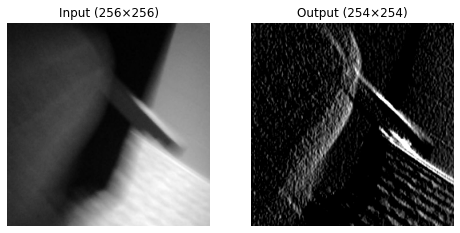

In [15]:
import numpy as np
import cv2
from pynq import Overlay, allocate
from IPython.display import display, clear_output
import matplotlib.pyplot as plt

# Load overlay and convolution IP
overlay = Overlay("design_1_wrapper.bit")
conv_ip = overlay.conv2d_edge_0  # Adjust if IP name differs

# Helper: write 64-bit buffer address to 2 registers
def write_addr(ip, reg_low, reg_high, addr):
    setattr(ip.register_map, reg_low, addr & 0xFFFFFFFF)
    setattr(ip.register_map, reg_high, (addr >> 32) & 0xFFFFFFFF)

# GStreamer camera pipeline
gst_str = (
    "v4l2src device=/dev/video0 ! "
    "image/jpeg, width=640, height=480, framerate=30/1 ! "
    "jpegdec ! "
    "videoconvert ! "
    "appsink"
)

# Open camera
cap = cv2.VideoCapture(gst_str, cv2.CAP_GSTREAMER)
if not cap.isOpened():
    raise Exception("❌ Unable to open webcam via GStreamer!")

print("📹 Live stream started. Use Stop (⏹) to end.")

try:
    while True:
        ret, frame = cap.read()
        if not ret:
            print("⚠️ Could not read frame.")
            continue

        # Convert to grayscale and resize
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        resized = cv2.resize(gray, (256, 256)).astype(np.uint8)

        # Allocate buffers
        in_buffer = allocate(shape=(256, 256), dtype=np.uint8)
        out_buffer = allocate(shape=(254, 254), dtype=np.uint8)  # 3x3 kernel

        np.copyto(in_buffer, resized)

        # Write addresses and start convolution
        write_addr(conv_ip, "input_r_1", "input_r_2", in_buffer.physical_address)
        write_addr(conv_ip, "output_r_1", "output_r_2", out_buffer.physical_address)
        conv_ip.register_map.CTRL.AP_START = 1
        while not conv_ip.register_map.CTRL.AP_DONE:
            pass

        # Read output
        output = out_buffer.copy()

        # Show side-by-side
        fig, axs = plt.subplots(1, 2, figsize=(8, 4))
        axs[0].imshow(resized, cmap='gray')
        axs[0].set_title("Input (256×256)")
        axs[0].axis("off")
        axs[1].imshow(output, cmap='gray')
        axs[1].set_title("Output (254×254)")
        axs[1].axis("off")

        clear_output(wait=True)
        display(fig)
        plt.close(fig)

        # Free buffers
        in_buffer.freebuffer()
        out_buffer.freebuffer()

except KeyboardInterrupt:
    print("🛑 Stream stopped by user.")

finally:
    cap.release()
    cv2.destroyAllWindows()
